<a href="https://colab.research.google.com/github/austiezr/DS-Unit-2-Build/blob/master/Austin_Robinson_DS_12_Unit_2_Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 12 Unit 2 Build - Predicting Student Performance As A Binary Class

In [0]:
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression, f_classif
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeClassifierCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score
from pdpbox import pdp, info_plots
from xgboost import XGBClassifier

## Load Data

In [2]:
!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip'
!unzip 'student.zip'

df = pd.read_csv('/content/student-mat.csv', sep=';')
df['course'] = 'Math'
df1 = pd.read_csv('/content/student-por.csv', sep=';')
df1['course'] = 'Language'
df = df.append(df1, ignore_index=True)

--2020-03-06 16:23:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20478 (20K) [application/x-httpd-php]
Saving to: ‘student.zip.3’

student.zip.3       100%[===================>]  20.00K  --.-KB/s    in 0.03s   

2020-03-06 16:23:58 (657 KB/s) - ‘student.zip.3’ saved [20478/20478]

Archive:  student.zip
replace student-mat.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace student-mat.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y A
  inflating: student-mat.csv         
replace student-por.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: student-por.csv         
replace student-merge.R? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: student-merge.R         
  inflating: student.txt             


## Wrangle Data / Create Target / Split

In [0]:
def wrangle(df):
  df['famsize'] = df['famsize'].map({'GT3': 1, 'LE3':0})
  df['address'] = df['address'].map({'U':1, 'R':0})
  df['Pstatus'] = df['Pstatus'].map({'A': 0, 'T':1})
  for col in ['schoolsup', 'famsup', 'paid', 'activities', 
              'nursery', 'higher', 'internet', 'romantic']:
    df[col] = df[col].map({'yes':1, 'no':0})

  for col in ['G1', 'G2', 'G3']:
    df[col] = df[col].replace({0: np.NaN})

  dfmean = df[['G1', 'G2', 'G3']]
  dfmean['Mean'] = dfmean.mean(axis=1)
  df['Mean'] = dfmean['Mean']
  df['Pass/Fail'] = df['G3']>=10

  df['Improved'] = (df['G2']-df['G1'])>0

  df = df.drop(columns=['school', 'sex'])

  return df

df = wrangle(df)

training, test = train_test_split(df, train_size=0.80, test_size=0.20, random_state=33)
train, val = train_test_split(training, train_size=0.80, test_size=0.20, random_state=33)

In [0]:
target = 'Pass/Fail'
features = train.drop(columns=[target, 'G3', 'Mean', 'G2', 'G1', 'Improved']).columns
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]
X_training = training[features]
y_training = training[target]

## Majority Class Baseline

In [5]:
df[target].value_counts(normalize=False)

True     814
False    230
Name: Pass/Fail, dtype: int64

## XGBClassifier

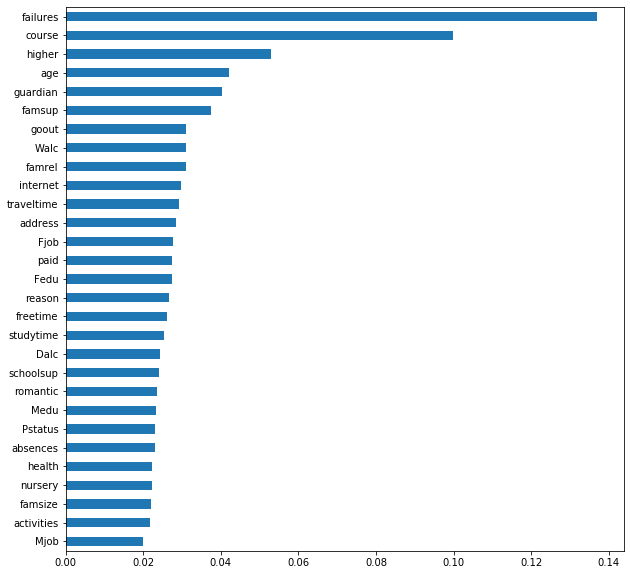

In [6]:
pipe = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    StandardScaler(),
    XGBClassifier(booster='gbtree', 
                  objective='binary:hinge', 
                  random_state=33,
                  )
)


pipe.fit(X_train, y_train)

encoded_columns = X_train.columns

coefficients = pd.Series(pipe.named_steps.xgbclassifier.feature_importances_[:]
                         [:], 
                         encoded_columns[:])
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();

### Validation Score

Train Precision: 0.8754325259515571

Validation Precision: 0.87248322147651



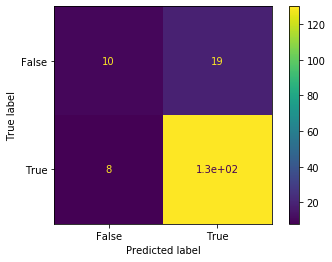

In [7]:
print(f'Train Precision: {precision_score(y_train, pipe.predict(X_train))}\n')
print(f'Validation Precision: {precision_score(y_val, pipe.predict(X_val))}\n')

plot_confusion_matrix(estimator=pipe, X=X_val, y_true=y_val);

### Test Score

Train Precision: 0.8754325259515571

Test Precision: 0.8415300546448088



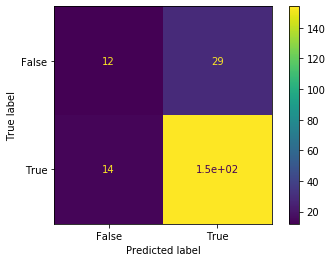

In [8]:
print(f'Train Precision: {precision_score(y_train, pipe.predict(X_train))}\n')
print(f'Test Precision: {precision_score(y_test, pipe.predict(X_test))}\n')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test);

## LogisticRegressionCV

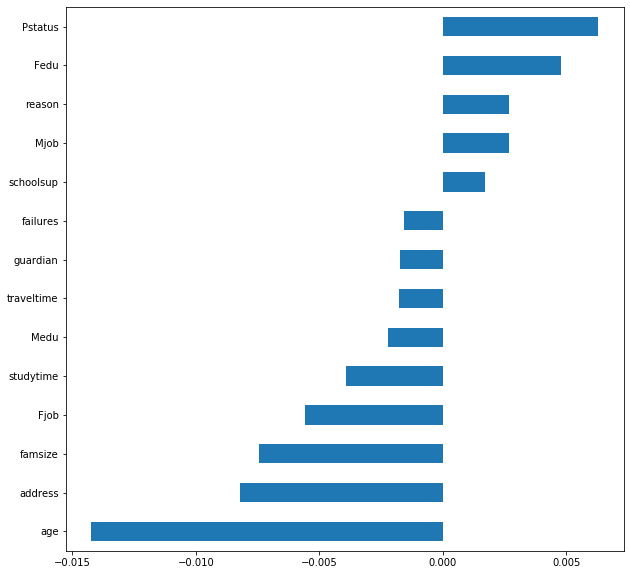

In [9]:
pipe = make_pipeline(
    TargetEncoder(),
    IterativeImputer(),
    StandardScaler(),
    PCA(),
    SelectKBest(k=14),
    LogisticRegressionCV(n_jobs=-1,
                         random_state=33,
                         solver='liblinear',
                         penalty='l2',
                         scoring='precision',
                         tol=1,
                         cv=10,
                         )
    )


pipe.fit(X_training, y_training)


encoded_columns = X_training.columns

coefficients = pd.Series(pipe.named_steps.logisticregressioncv.coef_[0][:pipe.named_steps.selectkbest.k], 
                         encoded_columns[:pipe.named_steps.selectkbest.k])
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();

### Test Score

Training Precision: 0.8528974739970282

Test Precision Score: 0.8546511627906976



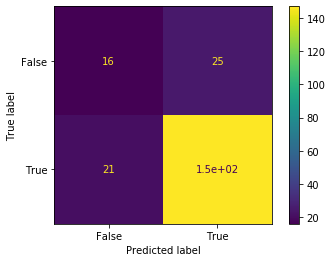

In [10]:
print(f'Training Precision: {pipe.score(X_training, y_training)}\n')
print(f'Test Precision Score: {pipe.score(X_test, y_test)}\n')

plot_confusion_matrix(estimator=pipe, X=X_test, y_true=y_test);

## Visualizations

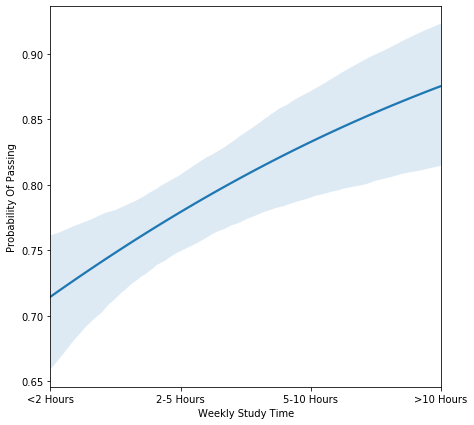

In [11]:
fig, ax = plt.subplots()

sns.regplot(X_training['studytime'], 
            y_training, 
            logistic=True, 
            fit_reg=True, 
            scatter=False,
            )

plt.xlabel('Weekly Study Time')
plt.xticks(np.arange(1, 5), 
           ('<2 Hours', '2-5 Hours', '5-10 Hours', '>10 Hours'))
plt.ylabel('Probability Of Passing')

fig.set_size_inches(7,7)

plt.savefig('studytime.png', dpi=150)

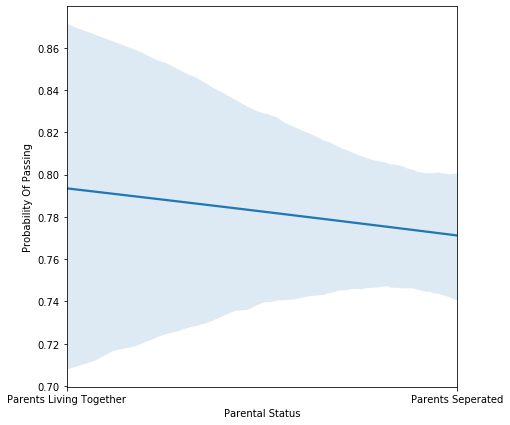

In [12]:
import seaborn as sns

fig, ax = plt.subplots()

sns.regplot(X_training['Pstatus'], 
            y_training, 
            logistic=True, 
            fit_reg=True, 
            scatter=False,
            )

plt.xlabel('Parental Status')
plt.xticks(np.arange(0,2), ('Parents Living Together', 'Parents Seperated'))
plt.ylabel('Probability Of Passing')

fig.set_size_inches(7,7)

plt.savefig('pstatus.png', dpi=150)

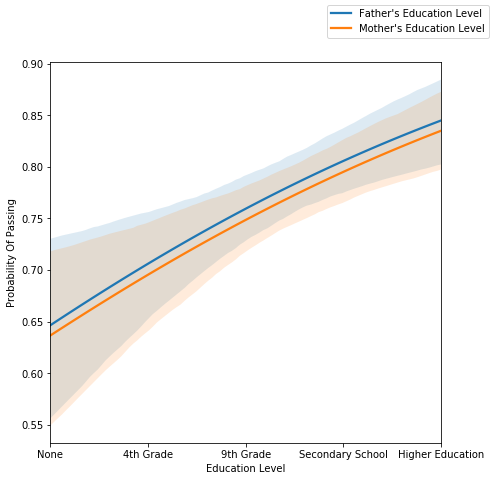

In [13]:
fig, ax = plt.subplots()

line1 = sns.regplot(X_training['Fedu'], 
            y_training, 
            logistic=True, 
            fit_reg=True, 
            scatter=False,
            )

line2 = sns.regplot(X_training['Medu'],
            y_training,
            logistic=True,
            fit_reg=True,
            scatter=False)

fig.legend((line1, line2),
           labels=("Father's Education Level", "Mother's Education Level"),
           loc='upper right')

plt.xlabel('Education Level')
plt.xticks(np.arange(0,5), ('None', '4th Grade', '9th Grade', 'Secondary School', 'Higher Education'))
plt.ylabel('Probability Of Passing')

fig.set_size_inches(7,7)

plt.savefig('edu.png', dpi=150)

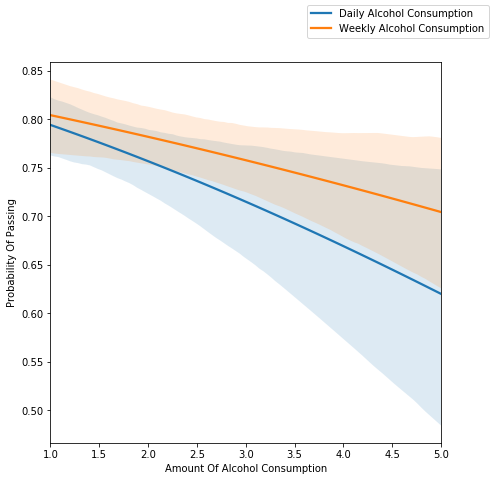

In [14]:
fig, ax = plt.subplots()

line1 = sns.regplot(X_training['Dalc'], 
            y_training, 
            logistic=True, 
            fit_reg=True, 
            scatter=False,
            )

line2 = sns.regplot(X_training['Walc'],
            y_training,
            logistic=True,
            fit_reg=True,
            scatter=False)

fig.legend((line1, line2),
           labels=("Daily Alcohol Consumption", "Weekly Alcohol Consumption"),
           loc='upper right')

plt.xlabel('Amount Of Alcohol Consumption')
plt.ylabel('Probability Of Passing')

fig.set_size_inches(7,7)

plt.savefig('alc.png', dpi=150)

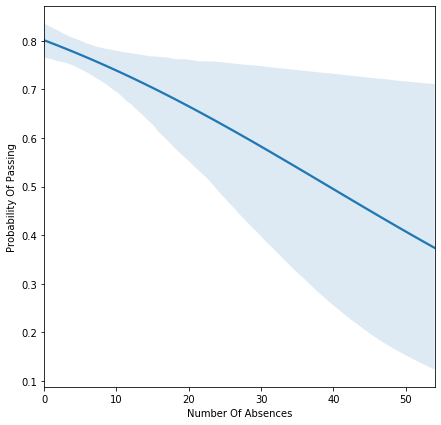

In [15]:
fig, ax = plt.subplots()

line1 = sns.regplot(X_training['absences'], 
            y_training, 
            logistic=True, 
            fit_reg=True, 
            scatter=False,
            )


plt.xlabel('Number Of Absences')
plt.ylabel('Probability Of Passing')

fig.set_size_inches(7,7)

plt.savefig('absences.png', dpi=150)

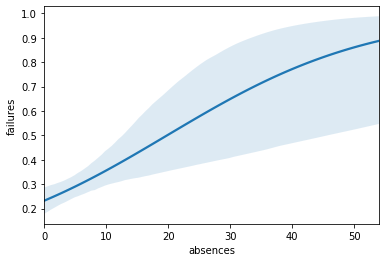

In [16]:
sns.regplot(X_training['absences'], 
            X_training['failures'], 
            logistic=True, 
            fit_reg=True, 
            scatter=False,
            )

In [0]:
pdpdf = training.copy()
pdpfeatures = ['age', 'studytime']

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc30a2a8eb8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fc30e3ca710>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


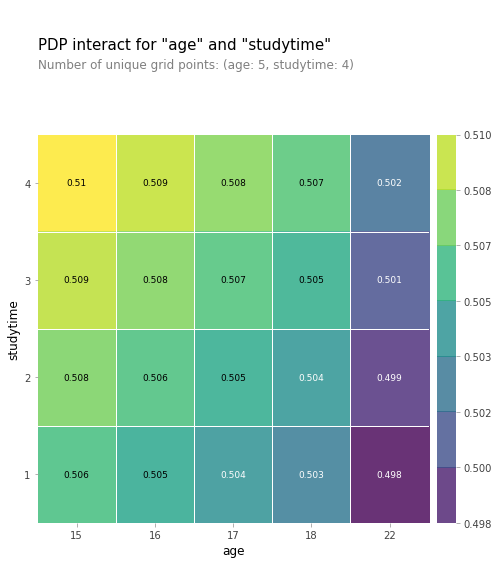

In [19]:
inter = pdp.pdp_interact(
    model=pipe,
    dataset=pdpdf,
    model_features=features,
    features=pdpfeatures
)

pdp.pdp_interact_plot(
    pdp_interact_out=inter,
    feature_names=pdpfeatures,
    plot_type='grid'
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


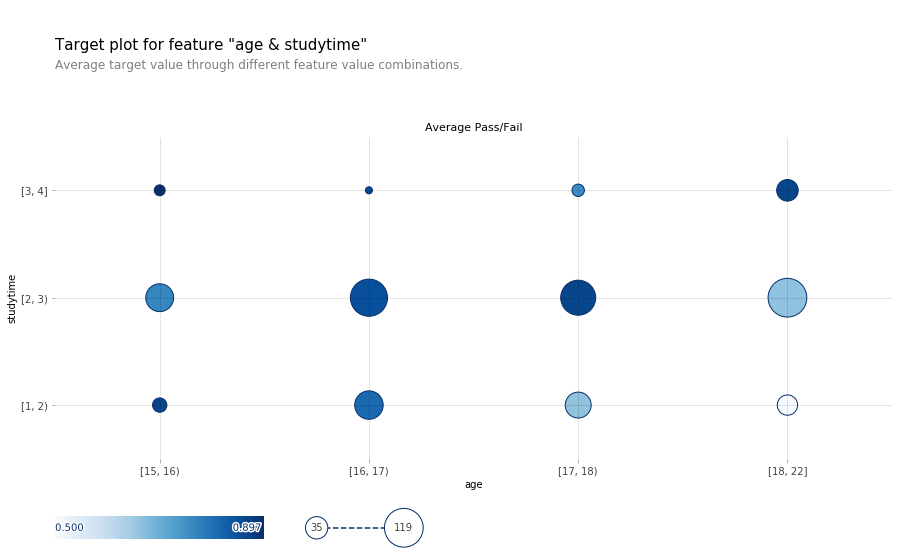

In [20]:
info_plots.target_plot_interact(pdpdf, features=pdpfeatures, feature_names=pdpfeatures, target=target);

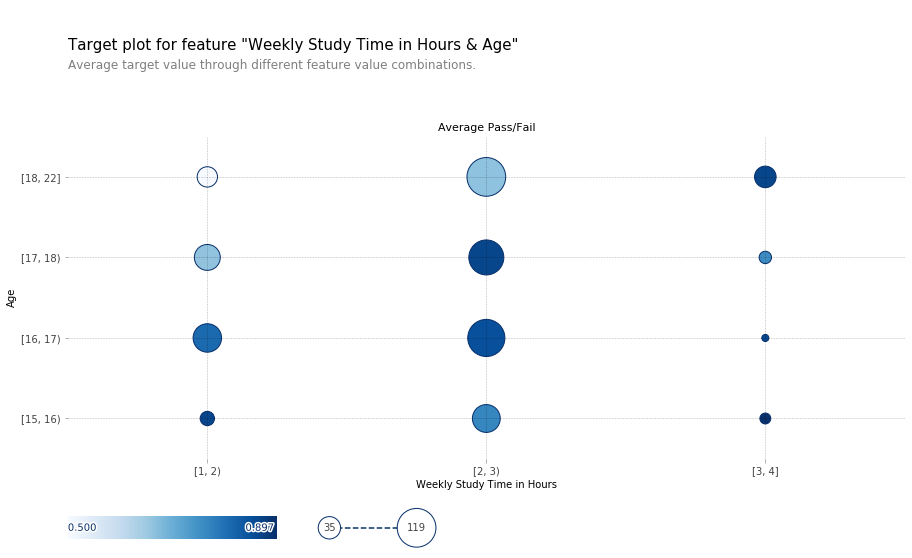

In [21]:
pdpfeatures = ['studytime', 'age']

info_plots.target_plot_interact(pdpdf, features=pdpfeatures, feature_names=['Weekly Study Time in Hours', 'Age'], target=target);

plt.savefig('pdp.png', dpi=150)